In [1]:
# https://www.knowledgehut.com/blog/data-science/types-of-classification-in-ml
from sklearn.datasets import make_blobs 
from collections import Counter 
from numpy import where 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle

def load_datasets(datasets_name="digits"):
    if datasets_name == "iris":
        dataset = datasets.load_iris()
    elif datasets_name == "wine":
        dataset = datasets.load_wine()
    elif datasets_name == "digits":
        dataset = datasets.load_digits()

    X = dataset.data
    y = dataset.target

    # Split the data for training and testing
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    return x_train, x_test, y_train, y_test

def saveReport(accuracy_history):
    data = {
        "accuracy_history": accuracy_history
    }
    pickle.dump(data, open("./PSO_report.pkl", "wb"))

x_train, x_test, y_train, y_test = load_datasets()


In [3]:
n_inputs = x_train[0].shape[0]
n_hidden = 20
n_classes = 10

# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss. It receives a set of parameters that must be 
    rolled-back into the corresponding weights and biases.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the 
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """
   
    # Roll-back the weights and biases
    W1_len = n_inputs * n_hidden
    b1_len = W1_len + n_hidden
    W2_len = b1_len + (n_hidden * n_classes)

    W1 = params[0:W1_len].reshape((n_inputs, n_hidden)) 
    b1 = params[W1_len:b1_len].reshape((n_hidden,))
    W2 = params[b1_len:W2_len].reshape((n_hidden, n_classes))
    b2 = params[W2_len:dimensions].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    z2 = a1.dot(W2) + b2  # Pre-activation in Layer 2
    logits = z2          # Logits for Layer 2

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood
    # N = 150  # Number of samples
    N = probs.shape[0]  # Number of samples
    corect_logprobs = -np.log(probs[range(N), y])
    loss = np.sum(corect_logprobs) / N

    return loss


def f(x):
    """Higher-level method to do forward_prop in the 
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)


def predict(X, pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    X: numpy.ndarray
        Input Iris dataset
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """

    # Roll-back the weights and biases
    W1_len = n_inputs * n_hidden
    b1_len = W1_len + n_hidden
    W2_len = b1_len + (n_hidden * n_classes)

    W1 = pos[0:W1_len].reshape((n_inputs, n_hidden)) 
    b1 = pos[W1_len:b1_len].reshape((n_hidden,))
    W2 = pos[b1_len:W2_len].reshape((n_hidden, n_classes))
    b2 = pos[W2_len:dimensions].reshape((n_classes,))
    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    z2 = a1.dot(W2) + b2  # Pre-activation in Layer 2
    logits = z2          # Logits for Layer 2

    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [4]:
import pyswarms as ps
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import sys

X = x_train
y = y_train

print(X.shape)
print(y.shape)

# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Call instance of PSO
# dimensions = (4 * 20) + (20 * 3) + 20 + 3
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(
    n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=1000, verbose=3)

2022-02-07 00:10:15,864 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


(1437, 64)
(1437,)


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.3
2022-02-07 00:12:52,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.3018379994746243, best pos: [1.03643204 0.44850118 0.42394807 ... 0.76364922 0.11655049 0.42987538]


Accuracy on Unseen Data: 0.07777777777777778


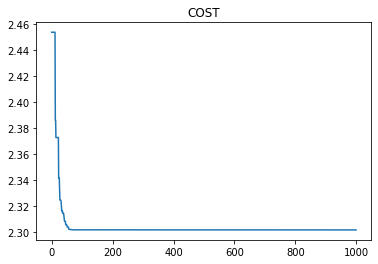

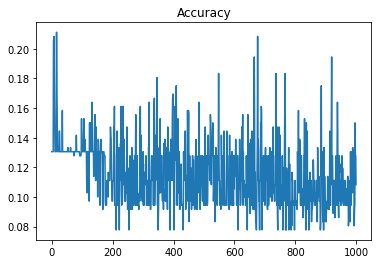

In [5]:
Test_acc = (predict(x_test, pos) == y_test).mean()

print("Accuracy on Unseen Data:", Test_acc)

plt.plot(optimizer.cost_history)
plt.title("COST")
plt.show()

pos_history = optimizer.pos_history
pos_history = optimizer.pos_history
acc_history = [max([(predict(x_test, pos) == y_test).mean() for pos in pos_pop]) for pos_pop in pos_history]
plt.plot(acc_history)
plt.title("Accuracy")
plt.show()

saveReport(acc_history)